# Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns

# Read Serology Data

,field_name,order,definition
0,evaluation_id,A1,The unique identifier for each evaluation.
1,date_performed,A2,This is the date the test was performed.
2,days_from_symptom,A3,Days from symptom onset to blood collection.
3,manufacturer,B1,Name of manufacturer or company that makes thi...
4,device,B2,"This is the proprietary name, or trade name, o..."
5,lot_number,B3,The manufacturer's unique identification of th...
6,panel,F1,The testing program's unique identification of...
7,sample_id,F2,The unique ID of the sample in the panel.
8,sample_no,F3,The sequence in which the sample was tested.
9,type,F4,The sample material.


In [3]:
df = pd.read_csv('../../data/covid19serology.csv')
df['date_performed'] = pd.to_datetime(df['date_performed'])
print(f"Records: {len(df)}")

Records: 13420


# Confusion Matrix

In [4]:
cols_id = ['manufacturer','device','sample_id']

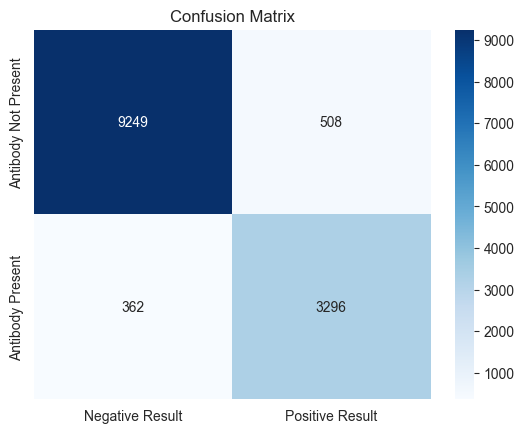

In [5]:
df_agree = (
    df.loc[
        df['antibody_agree'].isna()==False
        , cols_id + ['antibody_truth','antibody_agree']
    ].assign(
        actual = lambda x: (x['antibody_truth']=='Positive').astype(int)
    ).assign(
        predicted = lambda x: x['antibody_agree'].map({'TP':1,'FP':1,'TN':0,'FN':0,})
    )
)

cm = confusion_matrix(df_agree['actual'],df_agree['predicted'])
cm_df = (
    pd.DataFrame(
        cm, index = ['Antibody Not Present', 'Antibody Present'], columns = ['Negative Result', 'Positive Result']
    )
)

sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix')
plt.show()

# Accuracy Clusters

In [6]:
# Accuracy
sensitivity = ( #True positive rate 
    df_agree.loc[
        df_agree['actual']==1 #patients with antibodies
    ].groupby(
        ['manufacturer','device']
    ).agg(
        n_sensitivity = ('device','count')
        ,sensitivity = ('predicted','mean') #result = 1 when antibodies predicted
    )
)

specificity = ( #True negative rate
    df_agree.loc[
        df_agree['actual']==0 #patients without antibodies
    ].assign(
        no_antibodies_predicted = lambda x: x['antibody_agree'].map({'TP':0,'TN':1,'FP':0,'FN':1})
    ).groupby(
        ['manufacturer','device']
    ).agg(
        n_specificity = ('device','count')
        ,specificity = ('no_antibodies_predicted','mean')
    )
)

joined = pd.merge(
    sensitivity, specificity, 'outer', ['manufacturer','device']
)

joined

n_sensitivity  \
manufacturer                       device                                                              
Abacus Pharma International        SARS-CoV-2 IgM/IgG AB Antibody Rapid Test (Immu...             30   
Abbexa                             COVID-19 IgG/IgM Rapid Test Kit                                30   
Abbott                             Architect i1000 SARS-CoV-2 IgG                                 30   
Abbott Rapid Diagnostics Jena GmbH COVID-19 IgG Rapid Test Device                                 30   
Accel Diagnostics, LLC             Rapid C2T Total Antibodies (IgG/IgM) Card                      30   
...                                                                                              ...   
Zeus Scientific, Inc.              SARS-CoV-2 IgG Test System                                     30   
                                   Zeus ELISA SARS-CoV-2 Total Antibody Test System               30   
Zhongshan Bio-Tech Co LTD          SARS-CoV-2 IgM-IgG (GICA)                                      30   
Zhuhai Livzon Diagnostic Inc.      IgM/IgG Diagnostic Kit for IgM/IgG Antibody to ...             30   
Zhuhai Livzon Diagnostics Inc      Livzon IgM/IgG Diagnostic Kit for IgM/IgG Antib...             30   

                                                                                       sensitivity  \
manufacturer                       device                                                            
Abacus Pharma International        SARS-CoV-2 IgM/IgG AB Antibody Rapid Test (Immu...     0.766667   
Abbexa                             COVID-19 IgG/IgM Rapid Test Kit                        0.966667   
Abbott                             Architect i1000 SARS-CoV-2 IgG                         0.900000   
Abbott Rapid Diagnostics Jena GmbH COVID-19 IgG Rapid Test Device                         0.833333   
Accel Diagnostics, LLC             Rapid C2T Total Antibodies (IgG/IgM) Card              0.700000   
...                                                                                            ...   
Zeus Scientific, Inc.              SARS-CoV-2 IgG Test System                             0.933333   
                                   Zeus ELISA SARS-CoV-2 Total Antibody Test System       0.933333   
Zhongshan Bio-Tech Co LTD          SARS-CoV-2 IgM-IgG (GICA)                              0.966667   
Zhuhai Livzon Diagnostic Inc.      IgM/IgG Diagnostic Kit for IgM/IgG Antibody to ...     0.933333   
Zhuhai Livzon Diagnostics Inc      Livzon IgM/IgG Diagnostic Kit for IgM/IgG Antib...     0.866667   

                                                                                       n_specificity  \
manufacturer                       device                                                              
Abacus Pharma International        SARS-CoV-2 IgM/IgG AB Antibody Rapid Test (Immu...             80   
Abbexa                             COVID-19 IgG/IgM Rapid Test Kit                                80   
Abbott                             Architect i1000 SARS-CoV-2 IgG                                 80   
Abbott Rapid Diagnostics Jena GmbH COVID-19 IgG Rapid Test Device                                 80   
Accel Diagnostics, LLC             Rapid C2T Total Antibodies (IgG/IgM) Card                      80   
...                                                                                              ...   
Zeus Scientific, Inc.              SARS-CoV-2 IgG Test System                                     80   
                                   Zeus ELISA SARS-CoV-2 Total Antibody Test System               80   
Zhongshan Bio-Tech Co LTD          SARS-CoV-2 IgM-IgG (GICA)                                      80   
Zhuhai Livzon Diagnostic Inc.      IgM/IgG Diagnostic Kit for IgM/IgG Antibody to ...             80   
Zhuhai Livzon Diagnostics Inc      Livzon IgM/IgG Diagnostic Kit for IgM/IgG Antib...             80   

                                                      

### K-Means

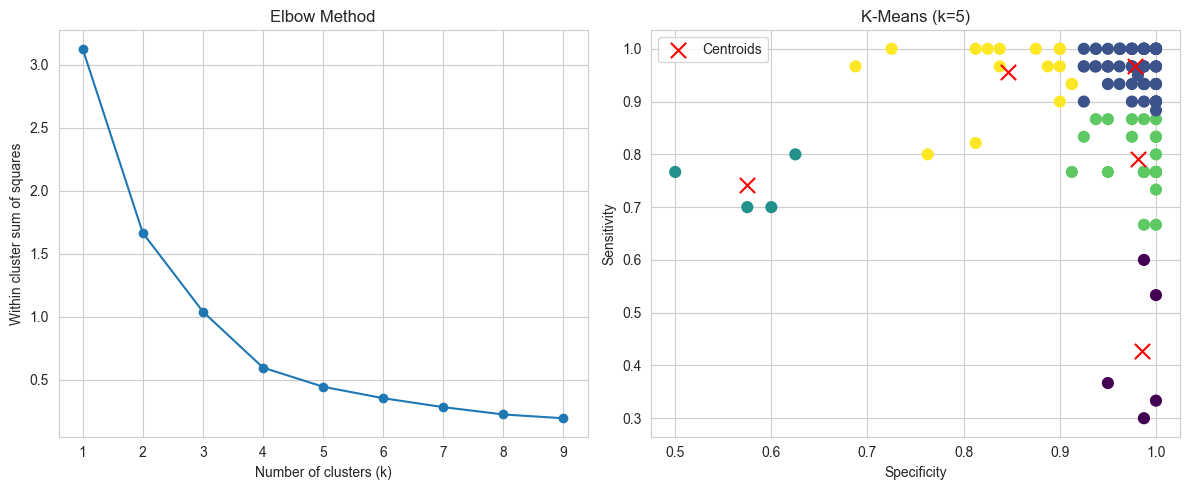

In [7]:
def k_means_and_plot(df: pd.DataFrame, k_final: int):
    # Features
    X = df[["specificity", "sensitivity"]]
    
    # --- Compute elbow ---
    inertias = []
    K = range(1, 10)
    for k in K:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X)
        inertias.append(km.inertia_) #within cluster sum of squared distances
    
    # --- Fit final KMeans ---
    kmeans = KMeans(n_clusters=k_final, random_state=42)
    df["cluster"] = kmeans.fit_predict(X)
    
    # --- Plot side-by-side ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left: Elbow
    ax1.plot(K, inertias, "o-")
    ax1.set_xlabel("Number of clusters (k)")
    ax1.set_ylabel("Within cluster sum of squares")
    ax1.set_title("Elbow Method")
    
    # Right: Clusters
    sc = ax2.scatter(df["specificity"], df["sensitivity"], c=df["cluster"], cmap="viridis", s=60)
    ax2.scatter(
        kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
        c="red", s=120, marker="x", label="Centroids"
    )
    ax2.set_xlabel("Specificity")
    ax2.set_ylabel("Sensitivity")
    ax2.set_title(f"K-Means (k={k_final})")
    ax2.legend(loc="best")
    
    plt.tight_layout()
    plt.show()
    
k_means_and_plot(joined, k_final=5)

### DBScan

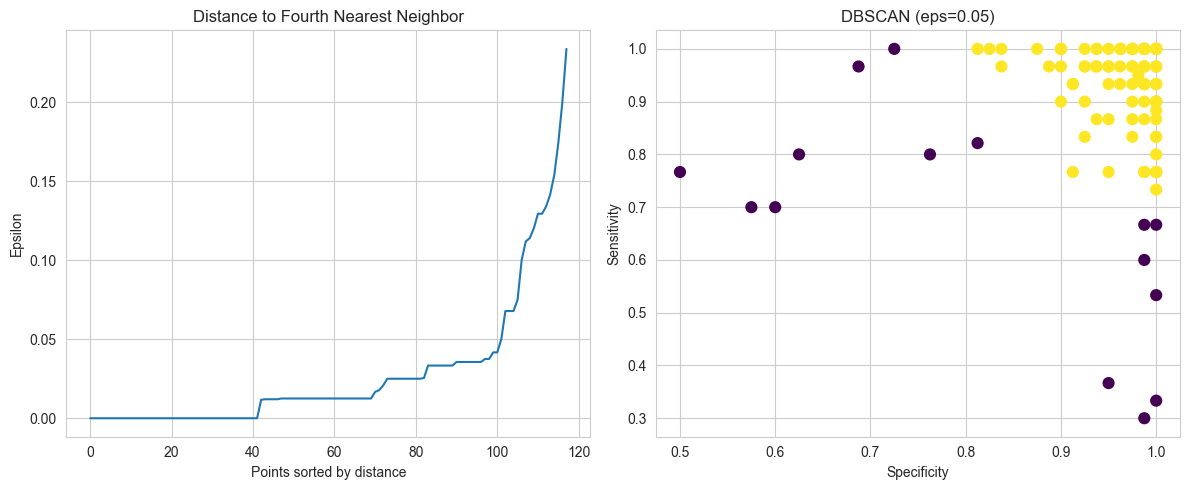

In [8]:
def dbscan_and_plot(df: pd.DataFrame, min_samples: int, eps_final: int):
    
    # Features
    X = df[["specificity", "sensitivity"]]

    # Use 2*n_features as rule of thumb
    
    # Distance to k-th nearest neighbor to determine epsilon
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)

    # k-distance for each point (distance to the furthest neighbor)
    k_distances = np.sort(distances[:, -1])    
    
    # --- Fit final DBSCAN ---
    db = DBSCAN(eps=eps_final, min_samples=4).fit(X)
    labels = db.labels_
    joined['cluster'] = pd.Series(labels, index=X.index)
    
    # --- Plot side-by-side ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left: K-Distances
    ax1.plot(k_distances)
    ax1.set_xlabel("Points sorted by distance")
    ax1.set_ylabel(f"Epsilon")
    ax1.set_title("Distance to Fourth Nearest Neighbor")    

    # Right: Clusters
    sc = ax2.scatter(df["specificity"], df["sensitivity"], c=df["cluster"], cmap="viridis", s=60)
    ax2.set_xlabel("Specificity")
    ax2.set_ylabel("Sensitivity")
    ax2.set_title(f"DBSCAN (eps={eps_final})")

    plt.tight_layout()
    plt.show()
   
dbscan_and_plot(joined, min_samples=4, eps_final=.05)

### GMM

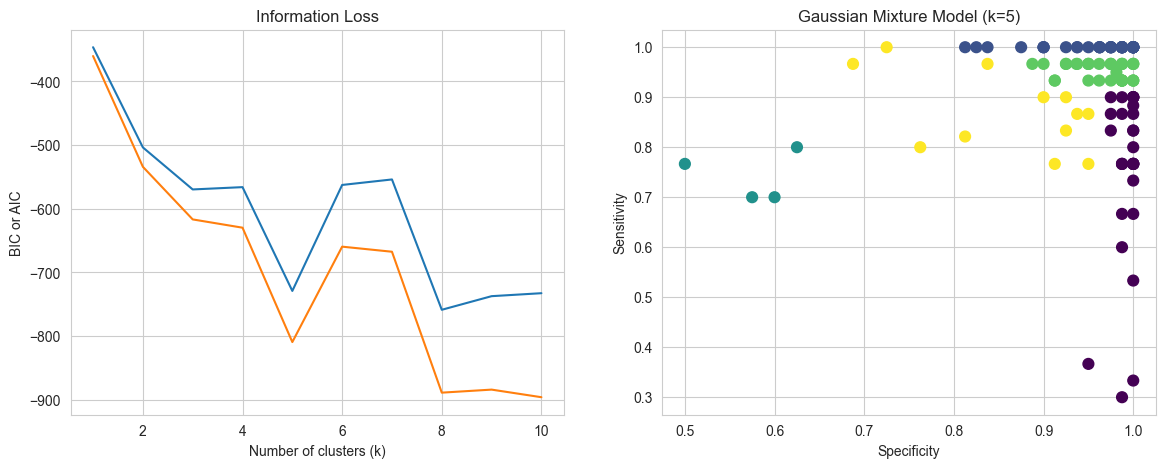

In [9]:
def gmm_and_plot(df: pd.DataFrame, k_final: int):
    
    # Features
    X = df[["specificity", "sensitivity"]]

    # Find best k
    k_range = range(1,11)
    bics = []
    aics = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
        bics.append(gmm.bic(X))
        aics.append(gmm.aic(X))

    # Run clusters
    gmm = GaussianMixture(n_components=k_final, random_state=42)
    labels = gmm.fit_predict(X)
    probs = gmm.predict_proba(X)
    df['cluster'] = pd.Series(labels, index=X.index)
    # df['gmm_cluster_probs'] = pd.Series(probs.tolist(), index=X.index)
    
    # --- Plot side-by-side ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Information Loss
    ax1.plot([k for k in k_range], bics)
    ax1.plot([k for k in k_range], aics)
    ax1.set_xlabel("Number of clusters (k)")
    ax1.set_ylabel(f"BIC or AIC")
    ax1.set_title("Information Loss")
    
    # Right: Clusters
    ax2.scatter(df["specificity"], df["sensitivity"], c=df["cluster"], cmap="viridis", s=60)
    ax2.set_xlabel("Specificity")
    ax2.set_ylabel("Sensitivity")
    ax2.set_title(f"Gaussian Mixture Model (k={k_final})")    
    
gmm_and_plot(joined, k_final=5)    

### Hierarchical

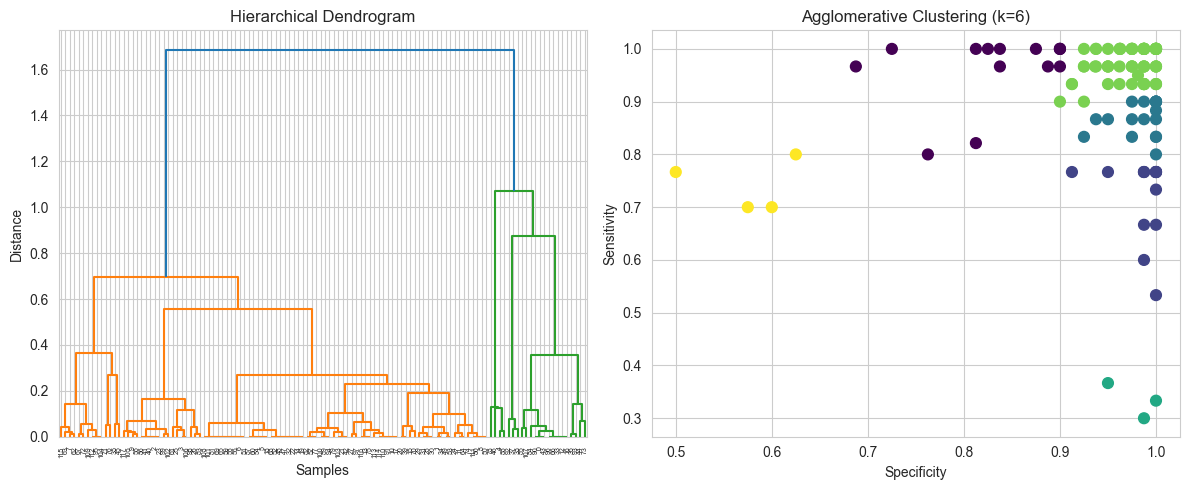

In [10]:
def hierarhical_cluster_and_plot(df: pd.DataFrame, k_final: int):

    X = df[["specificity", "sensitivity"]]  # your 2-feature clustering data
    
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])  # make scatter slightly wider
    
    # --- Left: Dendrogram ---
    ax0 = fig.add_subplot(gs[0])
    
    Z = sch.linkage(X, method='ward')  # compute linkage
    sch.dendrogram(Z, ax=ax0, orientation='top')
    ax0.set_title("Hierarchical Dendrogram")
    ax0.set_xlabel("Samples")
    ax0.set_ylabel("Distance")
    
    # --- Right: Scatterplot with chosen number of clusters ---
    k = k_final
    labels = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X)
    
    ax1 = fig.add_subplot(gs[1])
    sc = ax1.scatter(
        X.iloc[:,0], X.iloc[:,1],
        c=labels,
        cmap='viridis',
        s=60,
        # edgecolor='k'
    )
    ax1.set_title(f"Agglomerative Clustering (k={k})")
    ax1.set_xlabel("Specificity")
    ax1.set_ylabel("Sensitivity")
    
    plt.tight_layout()
    plt.show()

hierarhical_cluster_and_plot(joined, 6)

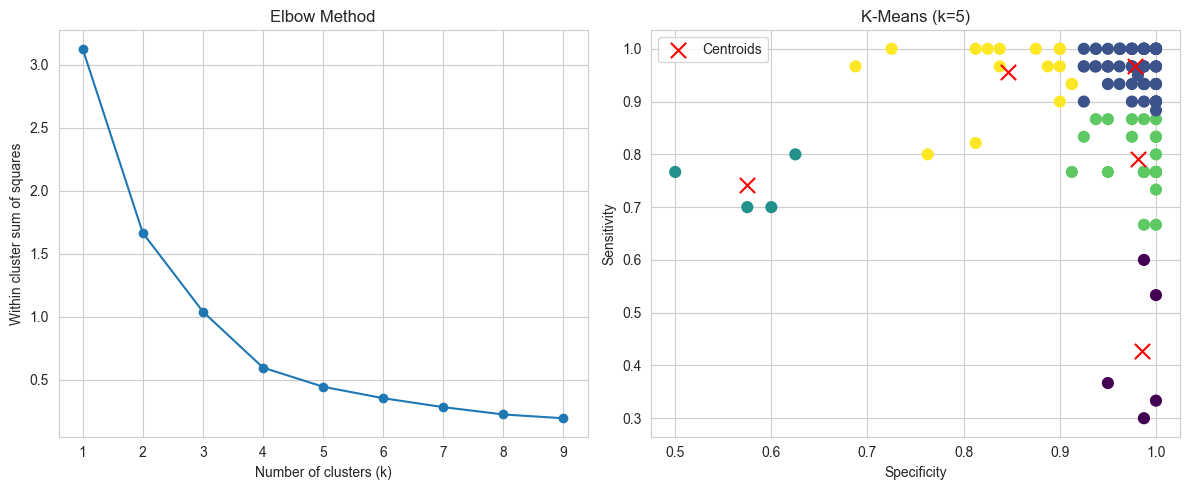

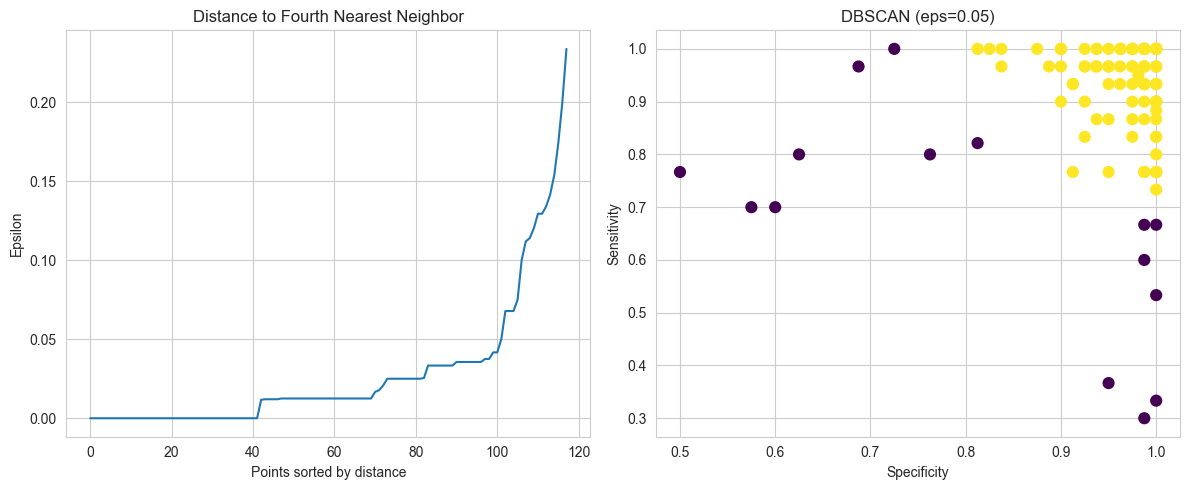

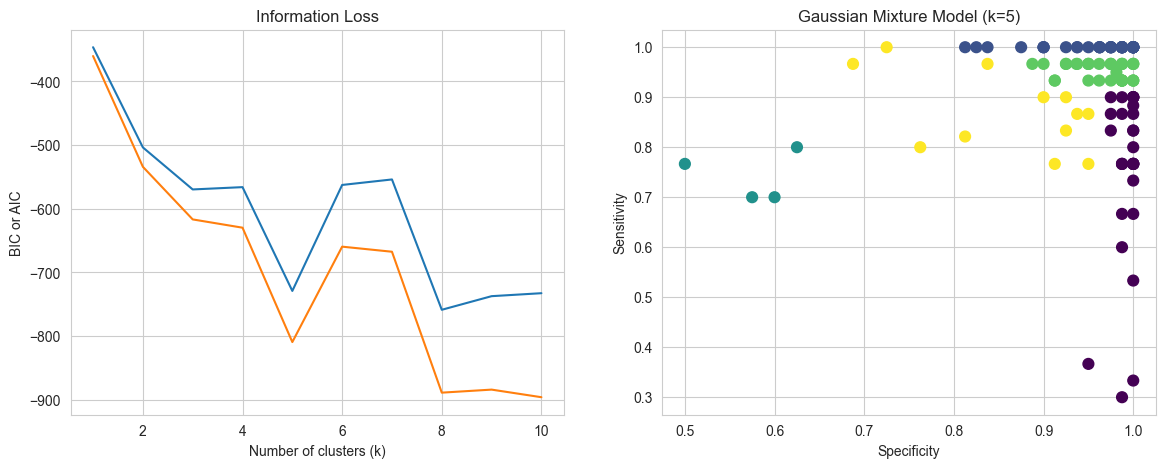

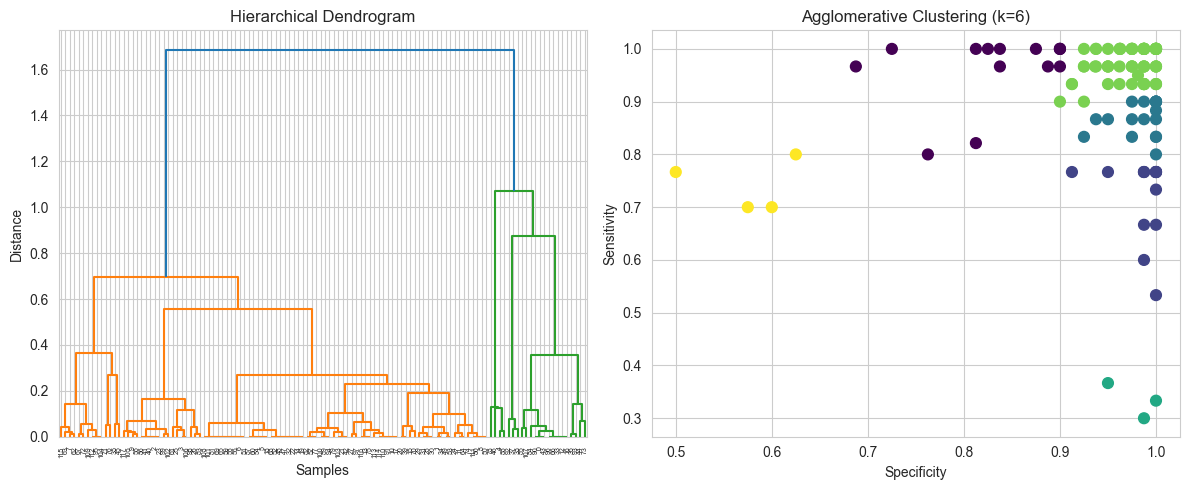

In [11]:
k_means_and_plot(joined, k_final=5)   
dbscan_and_plot(joined, min_samples=4, eps_final=.05)    
gmm_and_plot(joined, k_final=5)
hierarhical_cluster_and_plot(joined, 6)

# Predictive Values

In [12]:
#https://www.cdc.gov/mmwr/volumes/72/wr/mm7222a3.htm
# Article suggests range of prevalences is 0.684 to 0.964

In [16]:
# PPV Ranges per device
for i in range(9):
    prevalence = (i+1)/10
    prevalence_str = str(int(prevalence*100))
    joined[f"ppv_{prevalence}"] = (
        (prevalence * joined['sensitivity']) / (prevalence * joined['sensitivity'] + ((1 - prevalence) * (1 - joined['specificity'])))
    )
    joined[f"npv_{prevalence}"] = (
        ((1-prevalence) * joined['specificity']) / ((1-prevalence) * joined['specificity'] + (prevalence * (1 - joined['sensitivity'])))
    )
joined

n_sensitivity  \
manufacturer                       device                                                              
Abacus Pharma International        SARS-CoV-2 IgM/IgG AB Antibody Rapid Test (Immu...             30   
Abbexa                             COVID-19 IgG/IgM Rapid Test Kit                                30   
Abbott                             Architect i1000 SARS-CoV-2 IgG                                 30   
Abbott Rapid Diagnostics Jena GmbH COVID-19 IgG Rapid Test Device                                 30   
Accel Diagnostics, LLC             Rapid C2T Total Antibodies (IgG/IgM) Card                      30   
...                                                                                              ...   
Zeus Scientific, Inc.              SARS-CoV-2 IgG Test System                                     30   
                                   Zeus ELISA SARS-CoV-2 Total Antibody Test System               30   
Zhongshan Bio-Tech Co LTD          SARS-CoV-2 IgM-IgG (GICA)                                      30   
Zhuhai Livzon Diagnostic Inc.      IgM/IgG Diagnostic Kit for IgM/IgG Antibody to ...             30   
Zhuhai Livzon Diagnostics Inc      Livzon IgM/IgG Diagnostic Kit for IgM/IgG Antib...             30   

                                                                                       sensitivity  \
manufacturer                       device                                                            
Abacus Pharma International        SARS-CoV-2 IgM/IgG AB Antibody Rapid Test (Immu...     0.766667   
Abbexa                             COVID-19 IgG/IgM Rapid Test Kit                        0.966667   
Abbott                             Architect i1000 SARS-CoV-2 IgG                         0.900000   
Abbott Rapid Diagnostics Jena GmbH COVID-19 IgG Rapid Test Device                         0.833333   
Accel Diagnostics, LLC             Rapid C2T Total Antibodies (IgG/IgM) Card              0.700000   
...                                                                                            ...   
Zeus Scientific, Inc.              SARS-CoV-2 IgG Test System                             0.933333   
                                   Zeus ELISA SARS-CoV-2 Total Antibody Test System       0.933333   
Zhongshan Bio-Tech Co LTD          SARS-CoV-2 IgM-IgG (GICA)                              0.966667   
Zhuhai Livzon Diagnostic Inc.      IgM/IgG Diagnostic Kit for IgM/IgG Antibody to ...     0.933333   
Zhuhai Livzon Diagnostics Inc      Livzon IgM/IgG Diagnostic Kit for IgM/IgG Antib...     0.866667   

                                                                                       n_specificity  \
manufacturer                       device                                                              
Abacus Pharma International        SARS-CoV-2 IgM/IgG AB Antibody Rapid Test (Immu...             80   
Abbexa                             COVID-19 IgG/IgM Rapid Test Kit                                80   
Abbott                             Architect i1000 SARS-CoV-2 IgG                                 80   
Abbott Rapid Diagnostics Jena GmbH COVID-19 IgG Rapid Test Device                                 80   
Accel Diagnostics, LLC             Rapid C2T Total Antibodies (IgG/IgM) Card                      80   
...                                                                                              ...   
Zeus Scientific, Inc.              SARS-CoV-2 IgG Test System                                     80   
                                   Zeus ELISA SARS-CoV-2 Total Antibody Test System               80   
Zhongshan Bio-Tech Co LTD          SARS-CoV-2 IgM-IgG (GICA)                                      80   
Zhuhai Livzon Diagnostic Inc.      IgM/IgG Diagnostic Kit for IgM/IgG Antibody to ...             80   
Zhuhai Livzon Diagnostics Inc      Livzon IgM/IgG Diagnostic Kit for IgM/IgG Antib...             80   

                                                      

In [21]:
# joined.reset_index().to_csv('device_accuracy_and_predictive_values.csv', index=False, header=True)

In [17]:
#PPV per cluster centroid: k-means with k=5
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit_predict(joined[["specificity", "sensitivity"]])
df_clusters = (
    pd.DataFrame(
        kmeans.cluster_centers_, columns=["specificity", "sensitivity"]
    )
)
for i in range(9):
    prevalence = (i+1)/10
    prevalence_str = str(int(prevalence*100))
    df_clusters[f"ppv_{prevalence}"] = (
        (prevalence * df_clusters['sensitivity']) / (prevalence * df_clusters['sensitivity'] + ((1 - prevalence) * (1 - df_clusters['specificity'])))
    )
    df_clusters[f"npv_{prevalence}"] = (
        ((1-prevalence) * df_clusters['specificity']) / ((1-prevalence) * df_clusters['specificity'] + (prevalence * (1 - df_clusters['sensitivity'])))
    )    
df_clusters

,specificity,sensitivity,ppv_0.1,npv_0.1,ppv_0.2,npv_0.2,ppv_0.3,npv_0.3,ppv_0.4,npv_0.4,ppv_0.5,npv_0.5,ppv_0.6,npv_0.6,ppv_0.7,npv_0.7,ppv_0.8,npv_0.8,ppv_0.9,npv_0.9
0,0.985000,0.426667,0.759644,0.939255,0.876712,0.872969,0.924188,0.800348,0.949907,0.720439,0.966038,0.632086,0.977099,0.533875,0.985157,0.424061,0.991288,0.300458,0.996109,0.160293
1,0.978145,0.967150,0.830996,0.996282,0.917104,0.991674,0.949914,0.985811,0.967215,0.978101,0.977902,0.967507,0.985159,0.952040,0.990408,0.927331,0.994382,0.881572,0.997495,0.767897
2,0.575000,0.741667,0.162409,0.952454,0.303754,0.899023,0.427885,0.838542,0.537764,0.769517,0.635714,0.690000,0.723577,0.597403,0.802835,0.488208,0.874693,0.357513,0.940141,0.198276
3,0.980978,0.791304,0.822134,0.976908,0.912281,0.949500,0.946889,0.916443,0.965197,0.875788,0.976526,0.824577,0.984227,0.758085,0.989803,0.668271,0.994026,0.540257,0.997336,0.343091
4,0.846324,0.956162,0.408747,0.994278,0.608684,0.987216,0.727263,0.978283,0.805748,0.966621,0.861533,0.950753,0.903222,0.927905,0.935558,0.892171,0.961372,0.828370,0.982455,0.682045


In [22]:
# df_clusters.reset_index().to_csv('cluster_accuracy_and_predictive_values.csv', index=False, header=True)

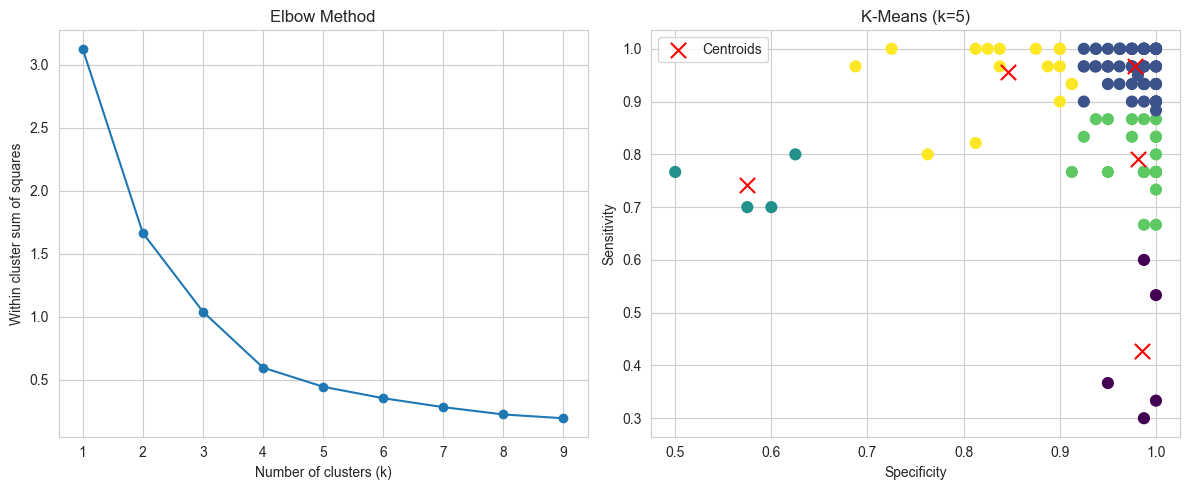

In [15]:
k_means_and_plot(joined, k_final=5)   